In [1]:
import os
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend([os.path.abspath('..')])

Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)] on win32


In [2]:
from denoising.denoise import Denoising
from denoising.atlas import Atlas
from denoising.dataset import Dataset
from denoising.helpers import *
from denoising.metrics import *


from seaborn import heatmap
from pathlib import Path

import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

## Denoising of fMRIprep output



### Create Dataset instance



In [3]:
# paste derivatives path
derivatives_path = '/data/Projects/TestRetest_NYU/bids/derivatives' #'/arch/OpenCloseProject/derivatives/'#'/data/Projects/TestRetest_NYU/bids/derivatives' '/arch/OpenCloseBeijin/INDI_Lite_NIFTI/derivatives/'
#
# enter number of runs
runs = 1
sessions = 3

# enter task name
task = 'rest'
tr = 2.5


data = Dataset(derivatives_path=derivatives_path, 
               sessions=sessions,
               TR=tr,
               runs=runs,
               task=task)

In [4]:
sub = data.sub_labels[0]

In [76]:
conf = data.get_confounds_one_subject(sub=data.sub_labels[0])

### qcfc


In [35]:
qcfc = QCFC(data)

In [ ]:
mean_fd_vec = np.zeros((2, len(data.sub_labels)))
for en, sub in enumerate(data.sub_labels):
    mean_fd_vec[0, en] = mean_fd(sub, 1)
    mean_fd_vec[1, en] = mean_fd(sub, 2)

In [28]:
import pingouin as pg
print(pg.ttest(x=mean_fd_vec[0], y=mean_fd_vec[1], alternative='two-sided', paired=True).round(2))

           T  dof alternative  p-val         CI95%  cohen-d   BF10  power
T-test  1.73   83   two-sided   0.09  [-0.0, 0.04]     0.22  0.499    0.5


In [8]:
def qc_fc(fc, run):
    qc_mat = np.zeros((fc.shape[1], fc.shape[2]))
    for i in range(fc.shape[1]):
        for t in range(fc.shape[2]):
            qc_mat[i, t] = np.corrcoef(fc[:, i, t], mean_fd_vec[run-1])[0, 1]
    return qc_mat


### Create Atlas instance

3 atlases are implemented:
1. `HCPex`, 426 ROI 
2. `Schaefer200`, 200 ROI
3. `AAL`, 116 ROI

In [7]:
# enter atlas name
atlas_name = 'HCPex'
mean_mask = '/home/tm/projects/OpenCloseProject/notebooks/mean_mask_trt_03.nii.gz'
atlas = Atlas(atlas_name=atlas_name, mean_mask=mean_mask)

## Denoising


**5 strategies:**

1. 24 parameters: 6 motion parameters, 6 temporal derivatives, 6 quadratic terms, and 6 quadratic expansions of the derivatives of motion estimates for a total 24 regressors;

2. aCompCor + 12P: 10 principal components calculated using a white matter and CSF combined anatomical mask, in addition to motion estimates and their temporal derivatives;

3. aCompCor50 + 12 parameters: principal components, which explain 50% of variance, calculated using a white matter and CSF combined anatomical mask, in addition to motion estimates and their temporal derivatives;

4. aCompCor + 24P: 10 principal components and 24 parameters;

5. aCompCor50 + 24P: same, principal components, which explain 50% of variance are used.

To each strategy global signal regressors (GSR) can be added (4 regressors: the global signal, its derivative, its square, and the derivative of its square). GSR is not used by default. 

By default, we add discrete cosines transformation basis regressors to handle low-frequency signal drifts. Instead, a bandpass filter (0.008 Hz and 0.09 Hz) can be used.

#### mean mask

In [8]:
from nilearn.maskers import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

In [10]:
atlas_img = nib.load(atlas.atlas_path)

In [11]:
masker_labels = atlas.atlas_labels

In [12]:
mask_path = '/home/tm/projects/OpenCloseProject/notebooks/mean_mask_trt_03.nii.gz'
mask = nib.load(mask_path)
mask.shape

(53, 65, 56)

In [13]:
# все что не ноль то один
atlas_img_bin = nib.Nifti1Image(
            (atlas_img.get_fdata() > 0).astype(np.uint8),
            atlas_img.affine,
            atlas_img.header,
            )


sum_masker_masked = NiftiLabelsMasker(
                        labels_img=atlas_img,
                        labels=masker_labels,
                        background_label=0,
                        mask_img=mask,
                        smoothing_fwhm=None,
                        standardize=False,
                        strategy="sum",
                        resampling_target='data',  
                        )

# no mask image here !!
sum_masker_unmasked = NiftiLabelsMasker(
                        labels_img=atlas_img,
                        labels=masker_labels,
                        background_label=0,
                        smoothing_fwhm=None,
                        standardize=False,
                        strategy="sum", # sum to see number of 
                        resampling_target='data',
                        )


# вместо мозга передаем бинаризованый атлас, 
# и считаем сколько вокселей попадает в маску (суммируем количество вокселей в рои)
n_voxels_in_masked_parcels = sum_masker_masked.fit_transform(atlas_img_bin)
# считаем сколько всего вокселей в рои в атласе
n_voxels_in_parcels = sum_masker_unmasked.fit_transform(atlas_img_bin)
# процент вокселей в маске
parcel_coverage = np.squeeze(n_voxels_in_masked_parcels / n_voxels_in_parcels)

In [18]:
np.save('./parcel_coverage_china_03.npy', parcel_coverage)

In [14]:
n_nodes = len(atlas.atlas_labels)
min_coverage = 0.5
coverage_thresholded = parcel_coverage < min_coverage
n_found_nodes = coverage_thresholded.size
n_bad_nodes = np.sum(parcel_coverage == 0)
n_poor_parcels = np.sum(
    np.logical_and(parcel_coverage > 0, parcel_coverage < min_coverage)
)
n_partial_parcels = np.sum(
    np.logical_and(parcel_coverage >= min_coverage, parcel_coverage < 1)
)

In [42]:
def new_mask_calc(img_pth, mask_pth, gs, thr):
    mskr = NiftiMasker(mask_pth)
    mskr.fit(img_pth)
    tr = mskr.transform(img_pth)
    a = np.array([tr[i] > (gs[i] * thr) for i in range(120)])
    t = tr * a
    return t

In [45]:
masks = []
thr = 0.6

for sub in data.sub_labels:
    try:
        func_files = data.get_func_files(sub)[0]
        mask_files = data.get_mask_files(sub)[0]
        gs = data.get_confounds_one_subject(sub)[0].global_signal.values

        mskr = NiftiMasker(mask_files)
        mskr.fit(func_files)
        tr = mskr.transform(func_files)
        a = np.array([tr[i] > (gs[i] * thr) for i in range(197)])
        t = tr * a

        out_mask = mskr.inverse_transform(t != 0)
        nib.save(out_mask.slicer[:, :, :, 0], f'/home/tm/projects/OpenCloseProject/masks/trt/sub-{sub}_run-1_new_mask_sliced.nii.gz')
    except IndexError:
        print(sub)
        continue
    

33259
58949
86146


In [15]:
mean_msk = np.zeros((63, 74, 47))
for m in os.listdir('/home/tm/projects/OpenCloseProject/masks/china/'):
    m_file = nib.load(f'/home/tm/projects/OpenCloseProject/masks/china/{m}')
    if m_file.shape != (63, 74, 47):
        print(m)
        break
    mean_msk += m_file.get_fdata()
    
mean_msk /= len(data.sub_labels)

In [48]:
mean_msk = np.zeros((53, 65, 56))
for m in os.listdir('/home/tm/projects/OpenCloseProject/masks/trt/'):
    m_file = nib.load(f'/home/tm/projects/OpenCloseProject/masks/trt/{m}')
    if m_file.shape != (53, 65, 56):
        print(m)
        break
    mean_msk += m_file.get_fdata()
    
mean_msk /= len(data.sub_labels)

In [88]:
mean_msk = np.zeros((120, 142, 50))
for m in os.listdir('/home/tm/projects/OpenCloseProject/masks/ihb/'):
    m_file = nib.load(f'/home/tm/projects/OpenCloseProject/masks/ihb/{m}')
    if m_file.shape != (120, 142, 50):
        print(m)
        break
    mean_msk += m_file.get_fdata()
    
mean_msk /= 84  

In [21]:
m_file = nib.load(f'/home/tm/projects/OpenCloseProject/masks/ihb/sub-001_run-1_new_mask_sliced.nii.gz')

In [49]:
np.save('./mean_mask_trt.npy', mean_msk)

In [37]:
mean_msk = np.load('./mean_mask.npy')

In [50]:
mean_msk = mean_msk > 0.3

In [51]:
np.sum(mean_msk)

63019

In [53]:
new_mask = nib.Nifti1Image(mean_msk.astype(np.uint8), m_file.affine)

In [54]:
nib.save(new_mask, 'mean_mask_trt_03.nii.gz')


In [79]:
conf = data.get_confounds_one_subject(sub=data.sub_labels[1])
gs = conf[0].global_signal.values

In [80]:
tr = mskr.transform_single_imgs(img_pth)

In [83]:
a = [tr[i] > (gs[i] * 0.7) for i in range(120)]
a = np.array(a)
t = tr * a

In [26]:
out_mask = mskr.inverse_transform(t != 0)

In [89]:
nib.save(out_mask.slicer[:, :, :, 0], './sub-002_run-1_new_mask_sliced.nii.gz')

In [28]:
msk = nib.load('./sub-002_run-1_new_mask_sliced.nii.gz')
msk.shape

(120, 142, 50)

# 

In [19]:
denoise = Denoising(data, atlas, 
                    # enter denoising options here
                    strategy=4, 
                    use_GSR=False, 
                    use_cosine=True, 
                    smoothing=None) 


Denoised time-series are saved as csv files in derivatives directory in time-series folder for every subject. 
Filename contains chosen atlas and strategy number. 

![Alt text](image.png)

In [ ]:
# don't pass any arguments to process all subjects in the directory
ts = denoise.denoise(save_outputs=True, folder='TRT_outputs')

failed to process: ['33259', '58949', '86146']

In [ ]:
# or pass subjects' labels you need 

sub_labels = [
    #'27641',
    data.sub_labels[10],
    data.sub_labels[0]
]

ts = denoise.denoise(sub_labels, save_outputs=False)

In [22]:
#parcel_coverage = np.load('/home/tm/projects/OpenCloseProject/notebooks/parcel_coverage_ihb_03.npy')
parcel_coverage = np.delete(parcel_coverage, [401, 372, 405])

In [23]:
ts2 = ts[0][0][:, parcel_coverage>0.5]

{401.0, 365.0, 398.0}

{396.0, 365.0, 401.0, 372.0, 405.0}

{401.0, 372.0, 405.0}


In [18]:
def fetch_ts(path, sub=None, run=1, task='rest', strategy=4, atlas_name='AAL'):
    ts = []
    if sub is None:
        sub = os.listdir(path)
    failed = []
    for i in sub:
        if not isinstance(i, str):
            i = str(i)
        if 'sub' in i:
            i = i[4:]
        try:
            name = f'sub-{i}_task-{task}_run-{run}_time-series_{atlas_name}_strategy-{strategy}.csv'
            path_to_file = os.path.join(path, f'sub-{i}', 'time-series', atlas_name, name)
            #print(path_to_file)
            ts.append(pd.read_csv(path_to_file).values)
        except FileNotFoundError:
            failed.append(i)
            continue
    print('no files available:', failed)
    return ts

### mean ts by network

In [6]:
import pandas as pd
df = pd.read_csv(r"C:\Users\ТМ\Desktop\BeijingEOEC.csv")

open_ids2 = df['SubjectID'].loc[df['Session_2'] == 'open'].values
open_ids3 = df['SubjectID'].loc[df['Session_3'] == 'open'].values

closed_ids2 = df['SubjectID'].loc[df['Session_2'] == 'closed'].values
closed_ids3 = df['SubjectID'].loc[df['Session_3'] == 'closed'].values

In [8]:
closed1 = np.load(r'C:\Users\ТМ\YandexDisk\IHB\Projects\OpenCloseFMRI\data\open_close_time-series\networks\china_close_mean_ts_by_network_HCPex.npy')

In [143]:
closed1 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  #sub=['001'], 
                  run=1, atlas_name='Brainnetome', strategy=6)

closed2 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  sub=closed_ids2, 
                  run=2, atlas_name='Brainnetome', strategy=6)

closed3 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  sub=closed_ids3, 
                  run=3, atlas_name='Brainnetome', strategy=6)

closed = closed1 + closed2 + closed3

no files available: []
no files available: []
no files available: []


In [144]:
for i in range(len(closed)):
    if len(closed[i]) < 240:
        print(i)

84


In [145]:
del closed[84]

In [146]:
opened2 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  sub=open_ids2, 
                  run=2, atlas_name='Brainnetome', strategy=6)
opened3 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  sub=open_ids3, 
                  run=3, atlas_name='Brainnetome', strategy=6)

opened = opened2 + opened3
for i in range(len(opened)):
    if len(opened[i]) < 240:
        print(i)

no files available: []
no files available: []
22


In [147]:
del opened[22]

#### hcp

In [105]:
import pandas as pd
hcp = pd.read_excel('/home/tm/projects/OpenCloseProject/atlas/HCPex_sorted.xlsx', index_col='HCPex_ID')

In [106]:
hcp.sort_index(inplace=True)

In [105]:
hcp = hcp.drop([401, 365, 398], axis=0)

In [107]:
hcp = hcp.drop([396, 365, 401, 372, 405], axis=0)

In [20]:
#401.0, 372.0, 405.0
hcp = hcp.drop([401, 372, 405], axis=0)

In [108]:
for i in closed:
    i.columns = hcp.index

In [109]:
for i in opened:
    i.columns = hcp.index

In [113]:

def mean_ts(ts, net):
    l = np.zeros((len(ts), len(ts[0])))
    for i in range(len(ts)):
        l[i] = np.mean(ts[i][hcp.loc[hcp.ColeAnticevic_network == net].index], axis=1)
        
    return l

In [114]:
unq = hcp.ColeAnticevic_network.unique()
all_net_cl = np.zeros((len(unq), len(closed), len(closed[0])))

for net in range(1, 15):
    all_net_cl[net-1] = mean_ts(closed, net)

In [115]:
all_net_op = np.zeros((len(unq), len(opened), len(opened[0])))

for net in range(1, 15):
    all_net_op[net-1] = mean_ts(opened, net)

In [118]:
np.savetxt('../network_names.txt', hcp.ColeAnticevic_network_label.unique(), fmt='%s')

#### schaefer

In [44]:
nets = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']

In [48]:
nets_d = {}
for v in nets:
    vl = []
    for k in trt1[0].columns:
        if v in k:
            vl.append(k)

    nets_d[v] = vl


In [93]:
del opened[24]

In [119]:
def sch_net(trt1):
    op_mean = np.zeros((7, len(trt1), len(trt1[0])))

    for net in range(7):
        nname = nets[net]
        for sub in range(len(trt1)):
            op_mean[net, sub] = np.mean(trt1[sub][nets_d[nname]].values, axis=1)
    return op_mean

In [128]:
op_mean = sch_net(closed)

In [129]:
np.save('/home/tm/projects/OpenCloseProject/files/china_close_mean_ts_by_network_Schaefer200.npy', op_mean)

In [123]:
cl_mean = np.zeros((7, 84, 120))

for net in range(7):
    nname = nets[net]
    for sub in range(84):
        cl_mean[net, sub] = np.mean(closed[sub][nets_d[nname]].values, axis=1)

In [124]:
np.save('../ihb_open_mean_ts_by_network_Schaefer200.npy', op_mean)

In [125]:
np.save('../ihb_close_mean_ts_by_network_Schaefer200.npy', cl_mean)

#### brainnetome

In [131]:
bntm = pd.read_csv('/home/tm/projects/OpenCloseProject/atlas/subregion_func_network_Yeo_updated.csv')

In [134]:
bntm.head(20)

,Label,subregion_name,region,Yeo_7network,Yeo_17network,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,1,A8m,SFG_L_7_1,6,17,NaN,NaN,NaN,NaN,NaN,Yeo 7 Network,NaN
1,2,A8m,SFG_R_7_1,4,8,NaN,NaN,NaN,NaN,NaN,ID,Network name
2,3,A8dl,SFG_L_7_2,7,16,NaN,NaN,NaN,NaN,NaN,1,Visual
3,4,A8dl,SFG_R_7_2,6,13,NaN,NaN,NaN,NaN,NaN,2,Somatomotor
4,5,A9l,SFG_L_7_3,7,17,NaN,NaN,NaN,NaN,NaN,3,Dorsal Attention
5,6,A9l,SFG_R_7_3,7,17,NaN,NaN,NaN,NaN,NaN,4,Ventral Attention
6,7,A6dl,SFG_L_7_4,3,6,NaN,NaN,NaN,NaN,NaN,5,Limbic
7,8,A6dl,SFG_R_7_4,3,6,NaN,NaN,NaN,NaN,NaN,6,Frontoparietal
8,9,A6m,SFG_L_7_5,2,3,NaN,NaN,NaN,NaN,NaN,7,Default
9,10,A6m,SFG_R_7_5,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
len(bntm)

246

In [155]:
bntm.columns

Index(['Label', 'subregion_name', 'region', 'Yeo_7network', 'Yeo_17network',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [156]:
cols = ['subregion_name', 'Yeo_7network']

In [139]:
bntm[['Unnamed: 10', 'Unnamed: 11']].iloc[2:9]

,Unnamed: 10,Unnamed: 11
2,1,Visual
3,2,Somatomotor
4,3,Dorsal Attention
5,4,Ventral Attention
6,5,Limbic
7,6,Frontoparietal
8,7,Default


In [140]:
ntw = {i+1: k for i, k in enumerate(bntm['Unnamed: 11'].iloc[2:9].values)}

In [151]:
nets = bntm['Unnamed: 11'].iloc[2:9].values

In [167]:
cc = bntm['region'].loc[bntm[cols[1]] == 1].values

In [168]:
cc

array(['FuG_L_3_2', 'FuG_R_3_2', 'FuG_R_3_3', 'PhG_R_6_2', 'PhG_L_6_3',
       'PhG_R_6_3', 'PhG_L_6_6', 'PhG_R_6_6', 'IPL_L_6_1', 'IPL_R_6_1',
       'PCun_L_4_3', 'PCun_R_4_3', 'CG_R_7_4', 'MVOcC_L_5_1',
       'MVOcC_R_5_1', 'MVOcC_L_5_2', 'MVOcC_R_5_2', 'MVOcC_L_5_3',
       'MVOcC_R_5_3', 'MVOcC_L_5_4', 'MVOcC_R_5_4', 'MVOcC_L_5_5',
       'MVOcC_R_5_5', 'LOcC_L_4_1', 'LOcC_R_4_1', 'LOcC_R_4_2',
       'LOcC_L_4_3', 'LOcC_R_4_3', 'LOcC_L_4_4', 'LOcC_R_4_4',
       'LOcC_L_2_1', 'LOcC_R_2_1', 'LOcC_L_2_2', 'LOcC_R_2_2'],
      dtype=object)

In [170]:
opened[0].columns

Index(['A8m_L', 'A8m_R', 'A8dl_L', 'A8dl_R', 'A9l_L', 'A9l_R', 'A6dl_L',
       'A6dl_R', 'A6m_L', 'A6m_R',
       ...
       'rTtha_L', 'rTtha_R', 'PPtha_L', 'PPtha_R', 'Otha_L', 'Otha_R',
       'cTtha_L', 'cTtha_R', 'lPFtha_L', 'lPFtha_R'],
      dtype='object', length=246)

In [153]:
def sch_net(trt1, nets_d):
    op_mean = np.zeros((7, len(trt1), len(trt1[0])))

    for net in range(7):
        nname = nets[net]
        for sub in range(len(trt1)):
            op_mean[net, sub] = np.mean(trt1[sub][nets_d[nname]].values, axis=1)
    return op_mean

In [154]:
sch_net(opened, ntw)

KeyError: 'Visual'

### Compute functional connectivity

In [13]:
trt1[1].shape

(197, 423)

In [25]:
trt_fc = functional_connectivity(trt1, 'correlation')

In [26]:
ts2.shape

(197, 407)

In [27]:
fc_cl = functional_connectivity(ts2, 'correlation')
#reor_cl = reorder_matrix(fc_cl, 'HCPex')
#fc_op = functional_connectivity(opened, 'correlation')
#reor_op = reorder_matrix(fc_op, 'HCPex')

In [27]:
fc_cl_old = functional_connectivity(closed, 'correlation')

In [30]:
fc_cl_old = trt_fc

In [95]:
fc_cl.shape

(407, 407)

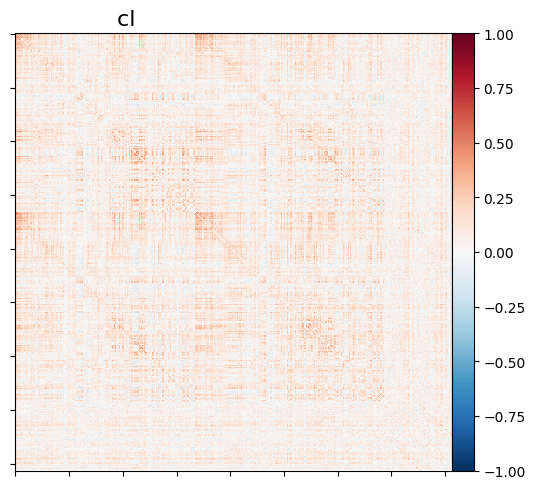

In [28]:
from nilearn import plotting
plotting.plot_matrix(
    fc_cl,
    labels=None,
    vmax=1,#np.max(fc6[0]),
    vmin=-1,#-np.max(fc6[0]),
    title="cl                              ",
    reorder=False)


In [29]:
fc_cl.shape

(114, 114)

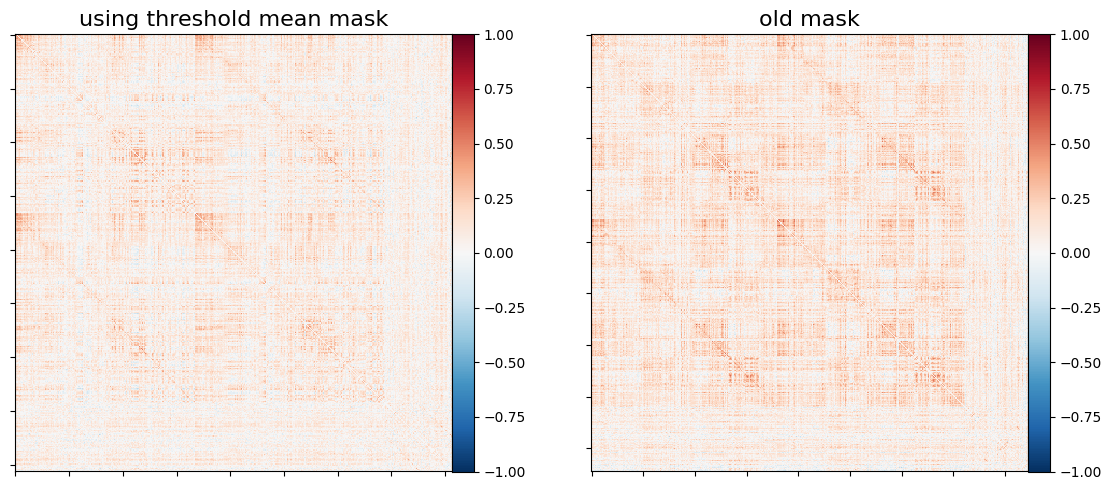

In [31]:
from nilearn import plotting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plotting.plot_matrix(
    fc_cl,
    labels=None,
    vmax=1,#np.max(fc6[0]),
    vmin=-1,#-np.max(fc6[0]),
    title="using threshold mean mask",
    reorder=False, axes=ax1)

plotting.plot_matrix(
    fc_cl_old[10],
    labels=None,
    vmax=1,#np.max(fc5[0]),
    vmin=-1,#-np.max(fc5[0]),
    title="old mask",
    reorder=False, axes=ax2)

In [38]:
np.corrcoef(fc_cl.flatten(), fc_cl_old[0].flatten())

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10404 and the array at index 1 has size 13456

In [89]:
np.corrcoef(fc_cl[0][2].flatten(), fc_cl[1][2].flatten())

array([[1.        , 0.15712201],
       [0.15712201, 1.        ]])

In [78]:
np.corrcoef(fc_cl[0][2].flatten(), fc_cl[0][0].flatten())

array([[1.        , 0.43801397],
       [0.43801397, 1.        ]])